### Create the data

In [1]:
import random
import jax
from jax import numpy as jnp
from flax import linen as nn
from flax.training import train_state
import math
import numpy as np
import optax

from IPython import display

/home/ganesh/.local/lib/python3.8/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
import sys
sys.path.append("..")
from res.plot_lib import plot_data, plot_model, set_default, plt

In [3]:
def plot_np_data(X, y, d=0, auto=False, zoom=1):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

In [4]:
def plot_jax_model(X, y, state):
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    data = jnp.array(np.vstack((xx.reshape(-1), yy.reshape(-1))).T, dtype=float)
    Z = state.apply_fn({"params": state.params}, data)
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_np_data(X, y)

In [5]:
set_default()

In [6]:
seed = 12345
random.seed(seed)
np.random.seed(seed)
key = jax.random.PRNGKey(seed=seed)
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3  # num_classes
H = 100  # num_hidden_units

In [7]:
X = np.zeros(shape=(N * C, D), dtype=float)
y = np.zeros(shape=(N * C, ), dtype=np.double)
for c in range(C):
    index = 0
    t = np.linspace(0, 1, N)
    # When c = 0 and t = 0: start of linspace
    # When c = 0 and t = 1: end of linpace
    # This inner_var is for the formula inside sin() and cos() like sin(inner_var) and cos(inner_Var)
    inner_var = np.linspace(
        # When t = 0
        (2 * math.pi / C) * (c),
        # When t = 1
        (2 * math.pi / C) * (2 + c),
        N
    ) + np.random.normal(size=N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        X[ix] = t[index] * np.array((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

print("Shapes:")
print("X:", tuple(X.shape))
print("y:", tuple(y.shape))

Shapes:
X: (3000, 2)
y: (3000,)


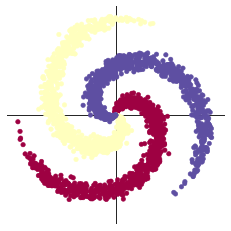

In [8]:
# visualise the data
plot_np_data(X, y)

### Linear model

In [9]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [10]:
class Sequential(nn.Module):
    """A simple model in flax"""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=H)(x)
        x = nn.Dense(features=C)(x)
        return x

# to track metrics like accuracy and loss
# define another pure function
@jax.jit
def train_step(state: train_state.TrainState, inputs: jnp.ndarray, labels: jnp.ndarray):
    def compute_loss(params):
        logits = state.apply_fn({"params": params}, inputs)
        labels_onehot = jax.nn.one_hot(labels, num_classes=C)
        cross_entropy_loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=labels_onehot))

        l2_regulariser = 0.5 * sum(
            jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

        return cross_entropy_loss + lambda_l2 * l2_regulariser
    
    loss = compute_loss(params=state.params)
    grad_fn = jax.grad(compute_loss, has_aux=False)
    grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    accuracy = jnp.mean(jnp.argmax(state.apply_fn({"params": state.params}, inputs), -1) == labels)
    metrics = {
      'loss': loss,
      'accuracy': accuracy,
    }
    return state, metrics

@jax.jit
def eval(state: train_state.TrainState, inputs: jnp.ndarray):
    return state.apply_fn({"params": state.params}, inputs)


In [11]:
def create_training_state(model: nn.Module, rng: jax.random.PRNGKey, learning_rate: float):
    params = model.init(rng, jnp.ones([1, 2])).get("params")
    tx = optax.sgd(learning_rate=learning_rate)
    return train_state.TrainState.create(params=params, apply_fn=model.apply, tx=tx)


In [12]:
model = Sequential()
state = create_training_state(
    model=model,
    rng = jax.random.PRNGKey(seed=42),
    learning_rate=learning_rate
)

for t in range(1000):
    state, metrics = train_step(state, inputs=X, labels=y)

In [13]:
print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, metrics.get("loss"), metrics.get("accuracy")))

[EPOCH]: 999, [LOSS]: 0.792271, [ACCURACY]: 0.499


Sequential()


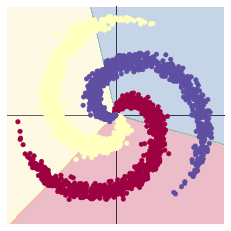

In [14]:
# Plot trained model
print(model)
plot_jax_model(X, y, state)

### Two-layered network

In [15]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [16]:
# nn package to create our linear model
# each Linear module has a weight and bias

class SequentialNonLinear(nn.Module):
    """A simple model in flax"""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=H)(x)
        x = nn.relu(x)
        x = nn.Dense(features=C)(x)
        return x

def create_training_state(model: nn.Module, rng: jax.random.PRNGKey, learning_rate: float):
    params = model.init(rng, jnp.ones([1, 2])).get("params")
    tx = optax.adam(learning_rate=learning_rate)
    return train_state.TrainState.create(params=params, apply_fn=model.apply, tx=tx)

In [17]:
model = SequentialNonLinear()
state = create_training_state(
    model=model,
    rng = jax.random.PRNGKey(seed=42),
    learning_rate=learning_rate
)

for t in range(1000):
    state, metrics = train_step(state, inputs=X, labels=y)

In [18]:
print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, metrics.get("loss"), metrics.get("accuracy")))

[EPOCH]: 999, [LOSS]: 0.137162, [ACCURACY]: 0.969


SequentialNonLinear()


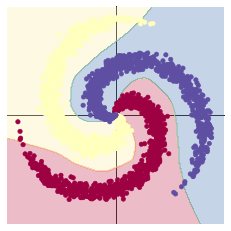

In [19]:
# Plot trained model
print(model)
plot_jax_model(X, y, state)